# Cost of Comfort

- Train a neural ODE model to predict temperature dynamics and power usage for a residential building
- Rollout for a month prediction of energy usage if temperature setpoint changes

In [1]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

## 0. Data
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [2]:
import pandas as pd 
data = pd.read_excel('./data/real-world-data.xls', sheet_name=['01-14-18', '01-15-18'])


ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [ ]:
n_samples = len(data)
index = range(0, n_samples*60, 60)
data.index = index

# resample to a given time step]
dt = 900
data = data.groupby([data.index // dt]).mean()

# add lag to target
def add_lags(data, cols, lags):
    for lag in range(1, lags+1):
        for col in cols:
            data[col+'-'+str(lag)] = data[col].shift(lag)
    return data

# scale energy
data['q_hvac'] = data['q_hvac'] / 1000
data['q_int'] = data['q_int'] / 1000
data['q_intz'] = data['q_intz'] / 1000
data['q_surf'] = data['q_surf'] / 1000
data['q_inf'] = data['q_inf'] / 1000
data['hvac_power'] = data['hvac_power'] / 1000

## 1. Models

Try two different mdoels
- lumped single zone dynamic model 
- neural ode


### 1.1 Physics-based Zone Dynamic Model


$$
    mC_{p,a}\frac{dT_z}{dt} = q_{hvac} + q_{int} + q_{intz} + q_{inf} + q_{surf}
$$

or 

$$
    \frac{dT_z}{dt} = \frac{1}{C}(q_{hvac} + q_{int} + q_{intz} + q_{inf} + q_{surf})
$$

Here we wll model this in dynax as a differentiable equation

#### Prepare Data

In [3]:
target_col = 'zone_temp'
feature_col = ['q_hvac', 'q_int', 'q_intz', 'q_surf', 'q_inf']
lags = 1
data1 = add_lags(data, [target_col], lags)
data1 = data1.dropna()
print(data1.head())

# split training and testing
ratio = 0.25
n_train = int(len(data1)*ratio)
data_train = data1.iloc[:n_train, :]
data_test = data1.iloc[n_train:, :]

# to model signals
x_train = jnp.array(data_train.loc[:, target_col+'-1'].values) 
u_train = jnp.array(data_train.loc[:, feature_col].values) # to kw
y_train = jnp.array(data_train.loc[:, target_col].values)
print("we have a training data set of :", u_train.shape[0])

x_test = jnp.array(data_test.loc[:, target_col+'-1'].values) 
u_test = jnp.array(data_test.loc[:, feature_col].values) # to kw
y_test = jnp.array(data_test.loc[:, target_col].values)
print("we have a training data set of :", u_test.shape[0])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


            t   csp   hsp  zone_temp  hvac_power   out_temp  out_solar  \
1  13911720.0  22.0  16.0  22.000026    1.115276  21.126667        0.0   
2  13912620.0  22.0  16.0  22.000006    0.936301  20.426667        0.0   
3  13913520.0  22.0  16.0  22.000004    0.798037  19.726667        0.0   
4  13914420.0  22.0  16.0  21.999997    0.685617  19.253333        0.0   
5  13915320.0  22.0  16.0  21.999994    0.602036  18.978333        0.0   

     q_hvac     q_int    q_surf    q_intz     q_inf  q_other  zone_temp-1  
1 -2.747126  0.329246  2.437253 -0.000029 -0.026020      0.0    22.698213  
2 -2.371847  0.329111  2.080346 -0.000031 -0.037443      0.0    22.000026  
3 -2.089611  0.328974  1.803762 -0.000031 -0.042982      0.0    22.000006  
4 -1.852856  0.324349  1.574744 -0.000033 -0.046123      0.0    22.000004  
5 -1.666868  0.324253  1.392437 -0.000036 -0.049728      0.0    21.999997  
we have a training data set of : 1439
we have a training data set of : 4320


#### Define Model

In [4]:
class ODE(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = 5
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        assert self.input_dim == jnp.shape(inputs)[-1]
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            self.C = self.param('C', nn.initializers.constant(1000.), ())
        
        def __call__(self, states, inputs):
            return 1./self.C * (states @ jnp.zeros((self.output_dim, self.output_dim)) + inputs @ jnp.ones((jnp.shape(inputs)[-1], 1)))
    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = ODE()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,5)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,5)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,5))))


                           ODE Summary                            
┏━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path ┃ module ┃ inputs         ┃ outputs        ┃ params       ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│      │ ODE    │ - float32[4,1] │ - float32[4,1] │              │
│      │        │ - float32[4,5] │ - float32[4,1] │              │
├──────┼────────┼────────────────┼────────────────┼──────────────┤
│ _fx  │ fx     │ - float32[4,1] │ float32[4,1]   │ C: float32[] │
│      │        │ - float32[4,5] │                │              │
│      │        │                │                │ 1 (4 B)      │
├──────┼────────┼────────────────┼────────────────┼──────────────┤
│ _fy  │ fy     │ - float32[4,1] │ float32[4,1]   │              │
│      │        │ - float32[4,5] │                │              │
├──────┼────────┼────────────────┼────────────────┼──────────────┤
│      │        │                │          Total │ 1 (4 B)  

In [5]:
out

Array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [6]:
class Model(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = ODE(state_dim = self.state_dim)
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        return jnp.squeeze(states_out, axis=-1)

model = Model(state_dim=1)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,5)))
init_out = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,5)))
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,5))))


                                 Model Summary                                  
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ Model         │ - float32[1]  │ float32[4]    │              │
│               │               │ -             │               │              │
│               │               │ float32[4,5]  │               │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ Differentiab… │ Differentiab… │ - float32[1]  │ -             │              │
│               │               │ -             │ float32[4,1]  │              │
│               │               │ float32[4,5]  │ -             │              │
│               │               │               │ float32[4,1]  │              │
├───────────────┼──────────

Extend model for batched data

In [7]:
# batch Model with shared parameters
VModel = nn.vmap(Model, in_axes=(0,0), out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1)
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,5)))
out = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,5)))
print(out.shape)

(32, 4)


#### Training and Evaluation

In [8]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_init, u)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(1e-01)
)

train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)

In [9]:
x_train.shape, u_train.shape

((1439,), (1439, 5))

In [10]:
n_epochs = 10000

# data shape vs model shape
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1))

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss}")


epoch: 0, loss: 0.023763321340084076
epoch: 100, loss: 0.023494092747569084
epoch: 200, loss: 0.023234227672219276
epoch: 300, loss: 0.022984392940998077
epoch: 400, loss: 0.022745169699192047
epoch: 500, loss: 0.022517122328281403
epoch: 600, loss: 0.022300750017166138
epoch: 700, loss: 0.022096561267971992
epoch: 800, loss: 0.021904941648244858
epoch: 900, loss: 0.02172628790140152
epoch: 1000, loss: 0.02156084217131138
epoch: 1100, loss: 0.0214088037610054
epoch: 1200, loss: 0.02127024345099926
epoch: 1300, loss: 0.021145114675164223
epoch: 1400, loss: 0.02103327214717865
epoch: 1500, loss: 0.020934388041496277
epoch: 1600, loss: 0.020848015323281288
epoch: 1700, loss: 0.020773595198988914
epoch: 1800, loss: 0.020710378885269165
epoch: 1900, loss: 0.020657552406191826
epoch: 2000, loss: 0.0206141397356987
epoch: 2100, loss: 0.020579155534505844
epoch: 2200, loss: 0.020551500841975212
epoch: 2300, loss: 0.02053014561533928
epoch: 2400, loss: 0.02051401324570179
epoch: 2500, loss: 0.0

In [11]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)

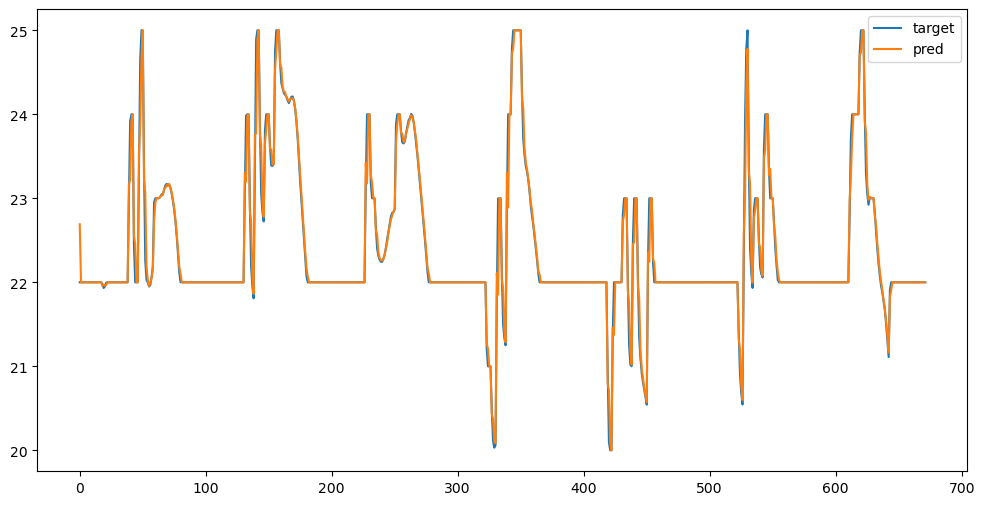

In [12]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:24*4*7,:], label='target')
plt.plot(y_pred[:24*4*7,:], label='pred')
plt.legend()

In [13]:
# test on predictions
# data shape vs model shape
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))

In [14]:
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

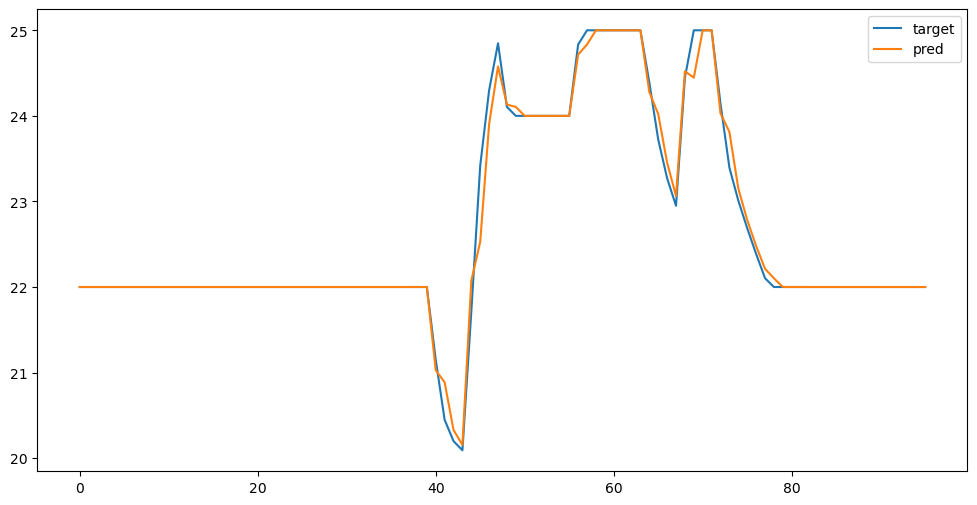

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:24*4*1,:], label='target')
plt.plot(y_pred_test[:24*4*1,:], label='pred')
plt.legend()

In [16]:
train_state.params

FrozenDict({
    params: {
        ODE_0: {
            _fx: {
                C: Array(806.17017, dtype=float32),
            },
        },
    },
})

### 1.2 Neural ODE

For realistic settings, here I only assume known measurements, such as outdoor air temperature, solar radiation, and energy usage

$$
    \frac{dT_z}{dt} = f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$

#### Prepare Data

In [17]:
target_col = 'zone_temp'
feature_col = ['q_hvac', 'out_temp', 'out_solar', 'h']

# add time index
data['h'] = (data['t'] % (24*3600)).astype('int') // 3600

lags = 8
data2 = add_lags(data, [target_col]+feature_col, lags)
data2 = data2.dropna()
print(data2.head())

# split training and testing
ratio = 0.25
n_train = int(len(data2)*ratio)
data_train = data2.iloc[:n_train, :]
data_test = data2.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'zone_temp-1'].values) 
u_train = jnp.array(data_train.loc[:, lag_cols + feature_col].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
u_mean = u_train.mean(axis=0)
u_std = u_train.std(axis=0)
u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'zone_temp-1'].values) 
u_test = jnp.array(data_test.loc[:, lag_cols + feature_col].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a training data set of :", u_test.shape[0])



             t   csp   hsp  zone_temp  hvac_power   out_temp  out_solar  \
8   13918020.0  22.0  16.0  21.999994    0.425249  18.006667        0.0   
9   13918920.0  22.0  16.0  21.999943    0.375886  17.456667        0.0   
10  13919820.0  22.0  16.0  21.999928    0.330152  16.906667        0.0   
11  13920720.0  22.0  16.0  21.999921    0.285947  16.356667        0.0   
12  13921620.0  22.0  16.0  21.999953    0.249736  16.100000        0.0   

      q_hvac     q_int    q_surf  ...  zone_temp-7  q_hvac-7  out_temp-7  \
8  -1.242595  0.323370  0.975170  ...    22.000026 -2.747126   21.126667   
9  -1.123492  0.323294  0.855822  ...    22.000006 -2.371847   20.426667   
10 -1.010136  0.323219  0.744202  ...    22.000004 -2.089611   19.726667   
11 -0.898139  0.323143  0.639257  ...    21.999997 -1.852856   19.253333   
12 -0.798366  0.322337  0.544888  ...    21.999994 -1.666868   18.978333   

    out_solar-7  h-7  zone_temp-8  q_hvac-8  out_temp-8  out_solar-8  h-8  
8           0.0 

#### Define Model

In [18]:
INPUT_DIM = u_train.shape[-1]

class NeuralODE(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = INPUT_DIM
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        assert self.input_dim == jnp.shape(inputs)[-1]
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            #self.dense1 = nn.Dense(features=4, use_bias=False)
            self.dense = nn.Dense(features=self.output_dim, use_bias=False)
        
        def __call__(self, states, inputs):
            out = self.dense(inputs)
            #out = nn.relu(out)
            #out = self.dense(out)
            return out

    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = NeuralODE()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM))))


                               NeuralODE Summary                                
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module    ┃ inputs          ┃ outputs        ┃ params            ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│           │ NeuralODE │ - float32[4,1]  │ - float32[4,1] │                   │
│           │           │ - float32[4,32] │ - float32[4,1] │                   │
├───────────┼───────────┼─────────────────┼────────────────┼───────────────────┤
│ _fx       │ fx        │ - float32[4,1]  │ float32[4,1]   │                   │
│           │           │ - float32[4,32] │                │                   │
├───────────┼───────────┼─────────────────┼────────────────┼───────────────────┤
│ _fx/dense │ Dense     │ float32[4,32]   │ float32[4,1]   │ kernel:           │
│           │           │                 │                │ float32[32,1]     │
│           │           │  

In [19]:
class NeuralModel(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = NeuralODE(state_dim = self.state_dim)
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        return jnp.squeeze(states_out, axis=-1)

model = NeuralModel(state_dim=1)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,INPUT_DIM)))
init_out = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,INPUT_DIM)))
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,INPUT_DIM))))


                              NeuralModel Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralModel   │ - float32[1]  │ float32[4]   │               │
│               │               │ -             │              │               │
│               │               │ float32[4,32] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Differentiab… │ Differentiab… │ - float32[1]  │ -            │               │
│               │               │ -             │ float32[4,1] │               │
│               │               │ float32[4,32] │ -            │               │
│               │               │               │ float32[4,1] │               │
├───────────────┼──────────

In [20]:
# batch Model with shared parameters
VModel = nn.vmap(NeuralModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1)
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
out = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
print(out.shape)

(32, 4)


#### Training and Evaluation

In [21]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_init, u)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adamw(1e-3)
)


In [22]:
train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [23]:
x_train.shape, u_train.shape 

((1438, 1), (1438, 1, 32))

In [24]:
n_epochs = 150000

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 90237.0625
epoch: 1000, loss: 469.1415100097656
epoch: 2000, loss: 113.61280822753906
epoch: 3000, loss: 27.08580207824707
epoch: 4000, loss: 8.415115356445312
epoch: 5000, loss: 4.725113868713379
epoch: 6000, loss: 3.2908084392547607
epoch: 7000, loss: 13.398212432861328
epoch: 8000, loss: 1.7951184511184692
epoch: 9000, loss: 1.5311731100082397
epoch: 10000, loss: 1.3336448669433594
epoch: 11000, loss: 1.1785436868667603
epoch: 12000, loss: 1.0539053678512573
epoch: 13000, loss: 0.9438106417655945
epoch: 14000, loss: 0.8507260084152222
epoch: 15000, loss: 0.8525367975234985
epoch: 16000, loss: 0.7001087069511414
epoch: 17000, loss: 1.3299139738082886
epoch: 18000, loss: 0.5842361450195312
epoch: 19000, loss: 0.6229351758956909
epoch: 20000, loss: 0.49383682012557983
epoch: 21000, loss: 0.46170541644096375
epoch: 22000, loss: 0.4225161671638489
epoch: 23000, loss: 0.39255237579345703
epoch: 24000, loss: 0.36704447865486145
epoch: 25000, loss: 0.34176141023635864
epoch:

In [25]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

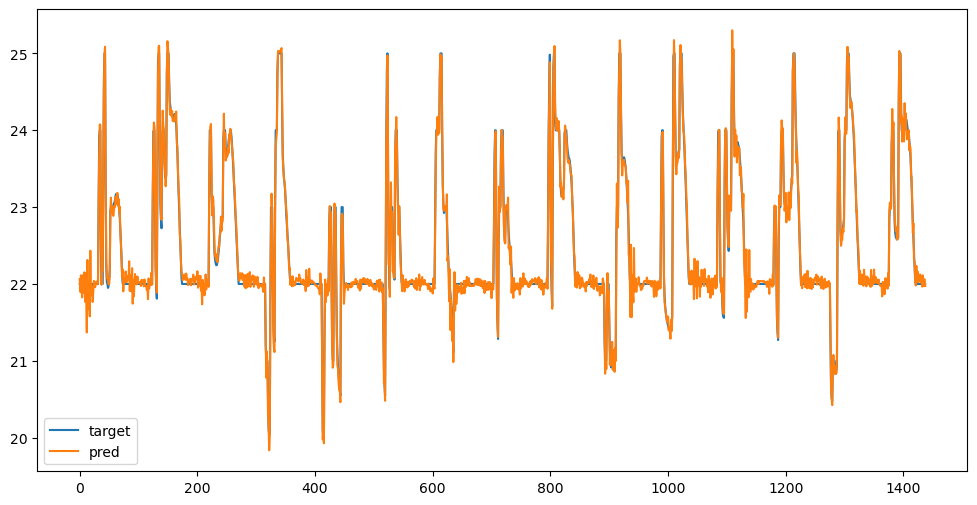

In [26]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

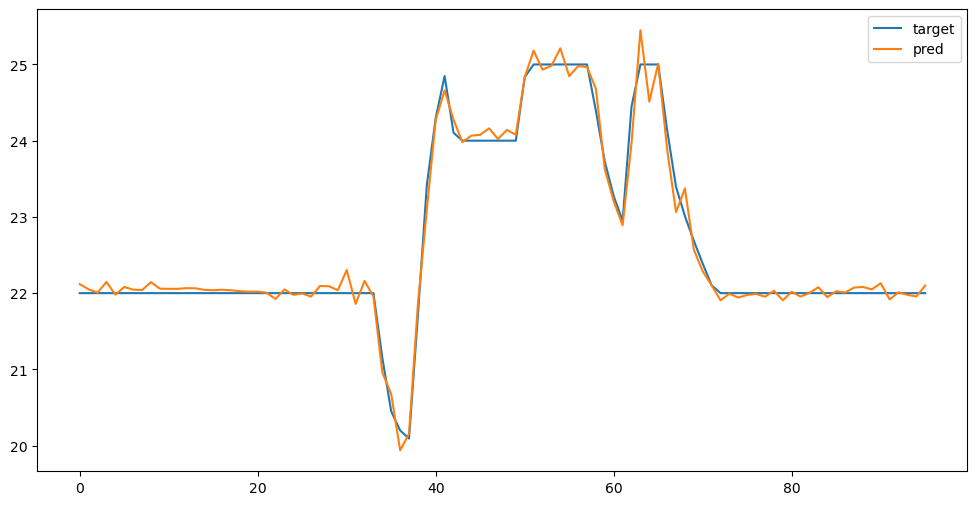

In [27]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:24*4*1,:], label='target')
plt.plot(y_pred_test[:24*4*1,:], label='pred')
plt.legend()

### 1.3 Physics-informed Neural ODE

In this section, I will use physics-informed neural ODE to learn the dynamics of the system.

$$
    \frac{dT_z}{dt} = \frac{1}{C}q_{hvac} + f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$


#### Prepare Data

In [28]:
target_col = 'zone_temp'
feature_col = ['q_hvac', 'out_temp', 'out_solar', 'h']

# add time index
data['h'] = (data['t'] % (24*3600)).astype('int') // 3600

lags = 8
data2 = add_lags(data, [target_col]+feature_col, lags)
data2 = data2.dropna()
print(data2.head())

# split training and testing
ratio = 0.25
n_train = int(len(data2)*ratio)
data_train = data2.iloc[:n_train, :]
data_test = data2.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'zone_temp-1'].values) 
u_train = jnp.array(data_train.loc[:, feature_col + lag_cols].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
normalize=False
if normalize:
    u_mean = u_train.mean(axis=0)
    u_std = u_train.std(axis=0)
    u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'zone_temp-1'].values) 
u_test = jnp.array(data_test.loc[:, feature_col + lag_cols].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
if normalize:
    u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a training data set of :", u_test.shape[0])


             t   csp   hsp  zone_temp  hvac_power   out_temp  out_solar  \
8   13918020.0  22.0  16.0  21.999994    0.425249  18.006667        0.0   
9   13918920.0  22.0  16.0  21.999943    0.375886  17.456667        0.0   
10  13919820.0  22.0  16.0  21.999928    0.330152  16.906667        0.0   
11  13920720.0  22.0  16.0  21.999921    0.285947  16.356667        0.0   
12  13921620.0  22.0  16.0  21.999953    0.249736  16.100000        0.0   

      q_hvac     q_int    q_surf  ...  zone_temp-7  q_hvac-7  out_temp-7  \
8  -1.242595  0.323370  0.975170  ...    22.000026 -2.747126   21.126667   
9  -1.123492  0.323294  0.855822  ...    22.000006 -2.371847   20.426667   
10 -1.010136  0.323219  0.744202  ...    22.000004 -2.089611   19.726667   
11 -0.898139  0.323143  0.639257  ...    21.999997 -1.852856   19.253333   
12 -0.798366  0.322337  0.544888  ...    21.999994 -1.666868   18.978333   

    out_solar-7  h-7  zone_temp-8  q_hvac-8  out_temp-8  out_solar-8  h-8  
8           0.0 

#### Define Model

In [139]:
INPUT_DIM = u_train.shape[-1]

class PINN(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = INPUT_DIM
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            self.C = self.param('C', nn.initializers.constant(1000.), ())
            #TODO: two observations:
            # 1. without relu, it is easier to train but may explode during training
            # 2. with relu, it is easier to get a smoother prediction
            self.disturbance = nn.Sequential([
                #nn.Dense(32),
                #nn.relu,
                nn.Dense(16),
                #nn.relu,
                nn.Dense(4),
                #nn.relu,
                nn.Dense(features=self.output_dim),# use_bias=False),
                ])
        
        def __call__(self, states, inputs):
            # assumed the first input is q_hvac
            q_hvac = jnp.take(inputs, jnp.array([0]), axis=-1)
            others = jnp.take(inputs, jnp.arange(1, jnp.shape(inputs)[-1]), axis=-1)
            # run model
            disturbance = self.disturbance(others)
            return 1./self.C * (q_hvac + disturbance)
    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = PINN()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,32)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,32)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,32))))


                                  PINN Summary                                  
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path           ┃ module     ┃ inputs        ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│                │ PINN       │ -             │ - float32[4,1] │               │
│                │            │ float32[4,1]  │ - float32[4,1] │               │
│                │            │ -             │                │               │
│                │            │ float32[4,32] │                │               │
├────────────────┼────────────┼───────────────┼────────────────┼───────────────┤
│ _fx            │ fx         │ -             │ float32[4,1]   │ C: float32[]  │
│                │            │ float32[4,1]  │                │               │
│                │            │ -             │                │ 1 (4 B)       │
│                │         

In [140]:
class PINNModel(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900
    regularizer:callable = nn.relu

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = PINN(state_dim = self.state_dim, name='dynamic')
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        # add regularizer for loss calculation
        if self.regularizer is not None:
            # a reduce function to get the last value in sow(), which stores previous value
            reduce_fn = lambda a, b: b 
            param_dynamics = dynamics.variables['params']['_fx']['C']
            self.sow('reg_loss', 'C', self.regularizer(param_dynamics), reduce_fn=reduce_fn)

        return jnp.squeeze(states_out, axis=-1)

In [141]:
# added a parameter regulizer
params_bounds = [500, 10000]
def param_regularizer(params, params_bounds):
    lb, ub = params_bounds
    loss = nn.relu(params - ub) + nn.relu(lb - params)
    return loss

In [142]:
model = PINNModel(state_dim=1, regularizer=lambda params: param_regularizer(params, params_bounds))

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,32)))
init_out, model_states = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,32)), mutable=['reg_loss'])
print(model_states)
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,32))))

FrozenDict({
    reg_loss: {
        C: Array(0., dtype=float32),
    },
})

                               PINNModel Summary                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ reg_loss   ┃ params      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ PINNModel  │ -          │ float32[4] │ C:         │             │
│            │            │ float32[1] │            │ float32[]  │             │
│            │            │ -          │            │            │             │
│            │            │ float32[4… │            │ 1 (4 B)    │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Different… │ Different… │ -          │ -          │            │             │
│            │            │ float32[1] │ float32[4… │            │             │
│            │            │ -   

In [143]:
# batch Model with shared parameters
VModel = nn.vmap(PINNModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None, 'reg_loss': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1, regularizer=lambda params: param_regularizer(params, params_bounds))
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
out, states = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)), mutable=['reg_loss'])
print(out.shape)

(32, 4)


#### Training and Evaluation

In [144]:
u_train.shape

(1438, 1, 32)

In [145]:
qhvac = jnp.take(u_train, jnp.array([0]), axis=-1)
qhvac.shape

others = jnp.take(u_train, jnp.arange(1, INPUT_DIM), axis=-1)
others.shape

(1438, 1, 31)

In [146]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred, regulizers = train_state.apply_fn(params, state_init, u, mutable=['reg_loss'])
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        reg_loss = sum(jax.tree_util.tree_leaves(regulizers["reg_loss"]))

        return pred_loss + reg_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(0.1)
)

train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [147]:
optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-03),
    optax.adam(0.01)
)

In [148]:
n_epochs = 50000

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 1988.4151611328125
epoch: 1000, loss: 0.4512438178062439
epoch: 2000, loss: 0.2949308156967163
epoch: 3000, loss: 0.22635726630687714
epoch: 4000, loss: 0.16897855699062347
epoch: 5000, loss: 0.1016753688454628
epoch: 6000, loss: 0.07045605033636093
epoch: 7000, loss: 0.05255566164851189
epoch: 8000, loss: 0.040451329201459885
epoch: 9000, loss: 0.03549306094646454
epoch: 10000, loss: 0.039757151156663895
epoch: 11000, loss: 0.052928049117326736
epoch: 12000, loss: 0.11670072376728058
epoch: 13000, loss: 41.47420120239258
epoch: 14000, loss: 19.319807052612305
epoch: 15000, loss: 9.245494842529297
epoch: 16000, loss: 4.206976413726807
epoch: 17000, loss: 1.8506256341934204
epoch: 18000, loss: 0.29317712783813477
epoch: 19000, loss: 0.23798491060733795
epoch: 20000, loss: 0.2783632278442383
epoch: 21000, loss: 0.1335349977016449
epoch: 22000, loss: 0.09269816428422928
epoch: 23000, loss: 0.07061757892370224
epoch: 24000, loss: 0.05021628364920616
epoch: 25000, loss: 0.04

In [149]:
loss

Array(0.02838048, dtype=float32)

In [150]:
grad

FrozenDict({
    params: {
        dynamic: {
            _fx: {
                C: Array(-0.00012306, dtype=float32),
                disturbance: {
                    layers_0: {
                        bias: Array([-1.1599870e-05, -3.5400502e-05,  2.2027394e-05, -2.6999449e-05,
                                2.1852029e-06,  5.0246417e-06, -6.1397222e-06, -2.9446266e-05,
                               -8.1606559e-06,  4.3816341e-05, -7.8533194e-06, -1.8352694e-06,
                               -8.1200415e-06,  1.8740757e-05, -4.0848274e-05, -7.2204421e-06],      dtype=float32),
                        kernel: Array([[-3.37381614e-04, -1.02961250e-03,  6.40665647e-04,
                                -7.85270706e-04,  6.35566248e-05,  1.46139646e-04,
                                -1.78571790e-04, -8.56436789e-04, -2.37351051e-04,
                                 1.27438642e-03, -2.28413381e-04, -5.33785205e-05,
                                -2.36169901e-04,  5.45067247e-04, -1.1

In [151]:
train_state.params

FrozenDict({
    params: {
        dynamic: {
            _fx: {
                C: Array(1020.61566, dtype=float32),
                disturbance: {
                    layers_0: {
                        bias: Array([ 3.3942308 ,  1.0667177 ,  0.90590155, -1.6125376 ,  0.07268067,
                               -0.7701081 ,  0.79775643, -1.513114  ,  1.4476831 , -1.1633748 ,
                                1.2607795 ,  0.48281568,  0.8679519 ,  0.16773646,  1.5447911 ,
                                0.6866887 ], dtype=float32),
                        kernel: Array([[ 2.2389503 ,  0.76464033,  1.4380622 , -2.0255983 ,  0.3170264 ,
                                 0.5738892 ,  0.73037696, -2.3064077 ,  0.582739  , -1.1749128 ,
                                 0.8853059 , -0.16213934,  0.67094773,  0.8631389 ,  1.1948599 ,
                                 0.3147255 ],
                               [ 1.9453421 ,  0.5875691 ,  1.4573865 , -1.7073582 ,  0.4038865 ,
                      

In [152]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

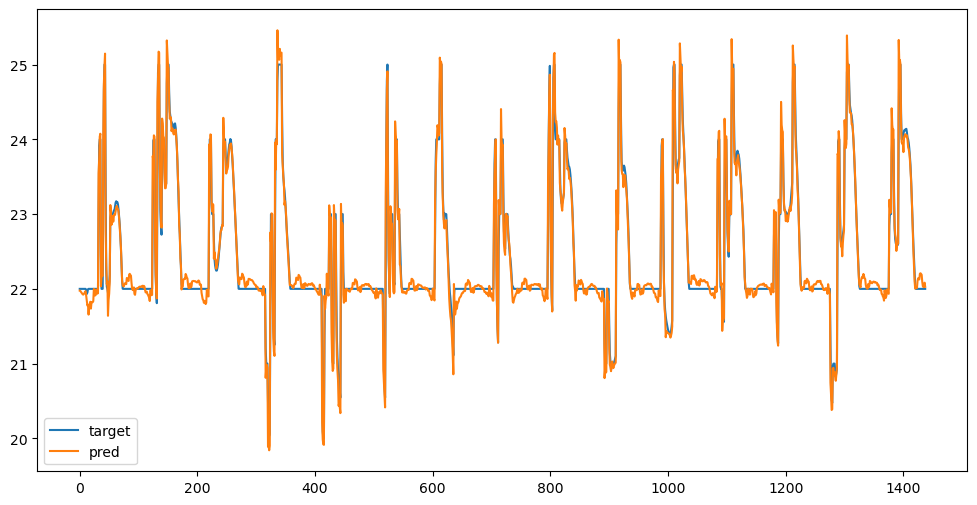

In [153]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

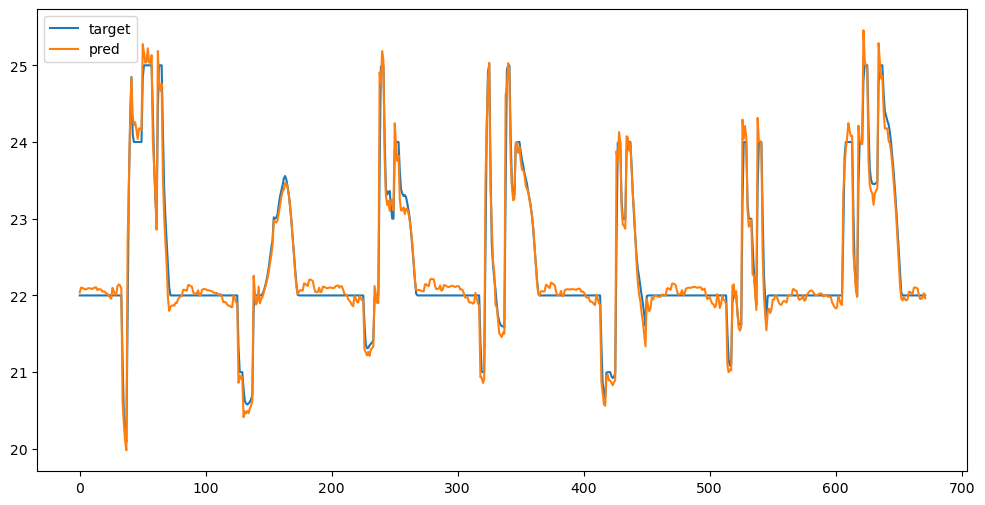

In [154]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:7*24*4,:], label='target')
plt.plot(y_pred_test[:7*24*4,:], label='pred')
plt.legend()